<a href="https://colab.research.google.com/github/priyanshsingh1765/Quantum-Machine-Learning-CPP-2024/blob/main/Assignment4/cpp_qml_assignment_4_22b1856.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qadence

INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.3/264.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 M

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform
from qadence import *
from torch import nn, optim, tensor, zeros_like, ones_like, linspace, manual_seed
from torch.autograd import grad
from torch import tan, rand, sin
import torch
import seaborn as sns

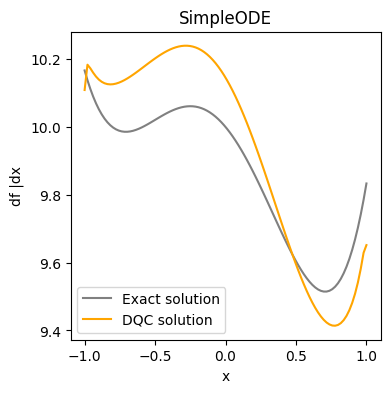

In [3]:
# randomseed
manual_seed(404)
N_QUBITS, DEPTH,LEARNING_RATE, N_POINTS= 6, 20, 0.01, 20
# building the DQC model
ansatz = hea(n_qubits=N_QUBITS, depth=DEPTH)
# the inputdata is encoded viaa feature map
fm = feature_map(n_qubits=N_QUBITS, param="x", fm_type="Chebyshev")
# choosing acost function
obs = ising_hamiltonian(n_qubits=N_QUBITS)
# building the circuit and the quantum model
circuit = QuantumCircuit(N_QUBITS, chain(fm,ansatz))
model = QNN(circuit=circuit, observable=obs,inputs=["x"])
# using Adamas an optimizer ofchoice
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# define aproblem-specific MSE lossfunction
# for theODE df/dx=4x^3+x^2-2x-1/2
def loss_fn(inputs, outputs):
    dfdx = grad(inputs=inputs, outputs=outputs.sum(), create_graph=True)[0]
    ode_loss = dfdx- (4*(inputs**3) + inputs**2 - 2*inputs - 0.5)
    boundary_loss = model(zeros_like(inputs)) - 10*ones_like(inputs)
    return ode_loss.pow(2).mean() + boundary_loss.pow(2).mean()

# collocationpoints sampling and training
for epoch in range(1000):
    opt.zero_grad()
    # the collocation points are sampledrandomly
    cp = tensor(
    uniform(low=-0.99,high=0.99, size=(N_POINTS,1)), requires_grad=True
    ).float()
    loss = loss_fn(inputs=cp, outputs=model(cp))
    loss.backward()
    opt.step()

# compare the solution to known ground truth
sample_points =linspace(-1.0, 1.0, steps=100).reshape(-1, 1)
# analyticalsolution
analytic_sol =(sample_points**4 + (1 / 3) * sample_points**3 - sample_points**2 - (1 / 2) * sample_points + 10)
# DQC solution
dqc_sol = model(sample_points).detach().numpy()
x_data = sample_points.detach().numpy()
# plot
plt.figure(figsize=(4, 4))
plt.plot(x_data,analytic_sol.flatten(), color="gray", label="Exact solution")
plt.plot(x_data,dqc_sol.flatten(), color="orange", label="DQC solution")
plt.xlabel("x")
plt.ylabel("df |dx")
plt.title("SimpleODE")
plt.legend()
plt.show()

# Part 2 - Partial Differential Equations
## Laplace equations in 2D
$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = 0$  
Over the domain (x,y) $\epsilon [0, 1]^2$  
With the 4 boundary conditions:
- u(0, y) = $sin(\pi y)$
- u(x, 0) = 0
- u(1, y) = $e^{-\pi}sin(\pi y)$
- u(x, 1) = 0

## The Analytical Solution
$e^{-\pi x}sin(\pi y)$



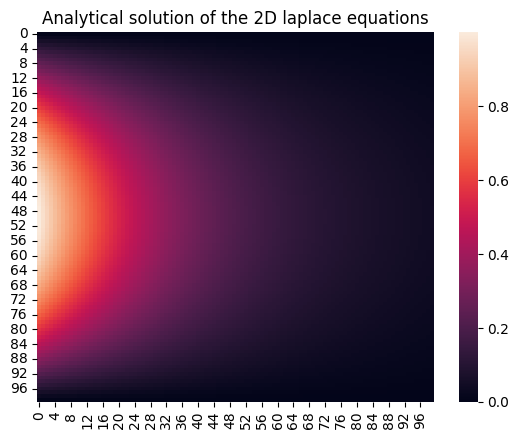

In [40]:
def analytical_sol_laplace(x, y):
    return np.exp(-np.pi * np.array(x)) * np.sin(np.pi * np.array(y))

grid_size = 100
x_points = np.linspace(0, 1, grid_size)
y_points = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x_points, y_points)
Z = analytical_sol_laplace(X, Y)

sns.heatmap(Z)
plt.title("Analytical solution of the 2D laplace equations")
plt.show()

## Solving the equations on a DQC

Epoch: 0 Loss: 5.258830332608619
Epoch: 1 Loss: 3.0767165427386303
Epoch: 2 Loss: 1.9165638339081152
Epoch: 3 Loss: 0.9098479315168673
Epoch: 4 Loss: 2.4118458966782255
Epoch: 5 Loss: 2.1892199996206054
Epoch: 6 Loss: 1.476995024670979
Epoch: 7 Loss: 0.7803304639256318
Epoch: 8 Loss: 0.8636074029553652
Epoch: 9 Loss: 1.0098050438826465
Epoch: 10 Loss: 0.6072456027386144
Epoch: 11 Loss: 0.557780021923679
Epoch: 12 Loss: 0.6786334719726874
Epoch: 13 Loss: 0.9014678479600831
Epoch: 14 Loss: 0.9311397471699654
Epoch: 15 Loss: 0.46104049345580117
Epoch: 16 Loss: 0.26456580728227075
Epoch: 17 Loss: 0.29295666431848566
Epoch: 18 Loss: 0.3199281309027762
Epoch: 19 Loss: 0.36882107649478657
Epoch: 20 Loss: 0.37683400357509317
Epoch: 21 Loss: 0.34458667387125874
Epoch: 22 Loss: 0.34157367019242796
Epoch: 23 Loss: 0.34890166173961323
Epoch: 24 Loss: 0.37781823695390926
Epoch: 25 Loss: 0.32936321607943747
Epoch: 26 Loss: 0.23518183672360912
Epoch: 27 Loss: 0.1938486747306804
Epoch: 28 Loss: 0.2047

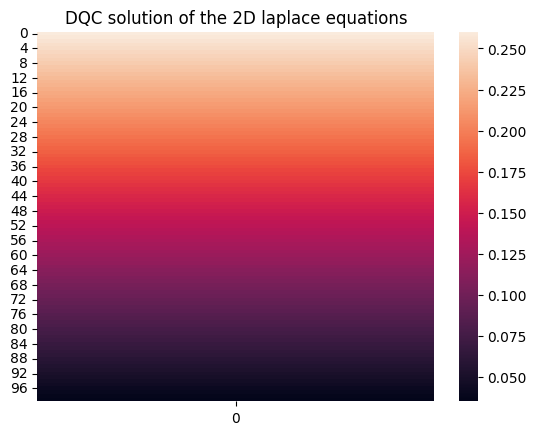

In [36]:
from itertools import product

# randomseed
manual_seed(404)
N_QUBITS, DEPTH, LEARNING_RATE, N_POINTS= 6, 20, 0.01, 150
VARIABLES =("x", "y")
# building the DQC model
ansatz = hea(n_qubits=N_QUBITS, depth=DEPTH)
# the inputdata is encoded viaa feature map
split = N_QUBITS // len(VARIABLES)
fm = kron(
     *[
          feature_map(n_qubits=split, support=support, param=param)
          for param,support in zip(
              VARIABLES,
              [
                  list(list(range(N_QUBITS))[i : i + split])
                  for i in range(N_QUBITS)
                  if i % split == 0
              ],
          )
      ]
)
# choosing acost function
obs = ising_hamiltonian(n_qubits=N_QUBITS)

# building the circuit and the quantum model
circuit = QuantumCircuit(N_QUBITS, chain(fm,ansatz))
model = QNN(circuit=circuit, observable=obs, inputs=VARIABLES)

# using Adamas an optimizer ofchoice
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# define aproblem-specific MSE lossfunction
# for theODE df/dx=4x^3+x^2-2x-1/2
def loss_fn(inputs, outputs):
    dfdxy = grad(inputs=inputs, outputs=outputs, grad_outputs=ones_like(outputs), create_graph=True, retain_graph=True)[0]
    d2fdxy2 = grad(inputs=inputs, outputs=dfdxy, grad_outputs=ones_like(dfdxy), create_graph=True, retain_graph=True)[0]

    ode_loss = d2fdxy2[:, 0] + d2fdxy2[:, 1]

    boundary_loss_1 = model(torch.cat((zeros_like(inputs[:, 0:1]), inputs[:, 1:2]), dim = 1)) - torch.sin(torch.pi * inputs[:, 1:2])
    boundary_loss_2 = model(torch.cat((inputs[:, 0:1], zeros_like(inputs[:, 1:2])), dim = 1))
    boundary_loss_3 = model(torch.cat((ones_like(inputs[:, 0:1]), inputs[:, 1:2]), dim = 1)) - ((torch.e)**(-torch.pi))*torch.sin(torch.pi * inputs[:, 1:2])
    boundary_loss_4 = model(torch.cat((inputs[:, 0:1], ones_like(inputs[:, 1:2])), dim = 1))

    return ode_loss.pow(2).mean() + boundary_loss_1.pow(2).mean() + boundary_loss_2.pow(2).mean() + boundary_loss_3.pow(2).mean() + boundary_loss_4.pow(2).mean()

# collocationpoints sampling and training
for epoch in range(1000):
    opt.zero_grad()
    # the collocation points are sampledrandomly
    cp = rand(size=(N_POINTS, len(VARIABLES)), requires_grad = True)

    loss = loss_fn(inputs = cp , outputs = model(cp))
    loss.backward()
    opt.step()

    print(f"Epoch: {epoch} Loss: {loss.item()}")

# compare the solution to known ground truth
sample_points_1d =linspace(0, 1.0, steps=100).reshape(-1, 1)
sample_points = torch.cat((sample_points_1d, sample_points_1d), dim = 1)

# analyticalsolution
analytic_sol = analytical_sol_laplace(sample_points_1d, sample_points_1d)

# DQC solution
dqc_sol = model(sample_points).detach().numpy()
x_data = sample_points_1d.detach().numpy()
y_data = sample_points_1d.detach().numpy()

# plot
sns.heatmap(dqc_sol)
plt.title("DQC solution of the 2D laplace equations")
plt.show()

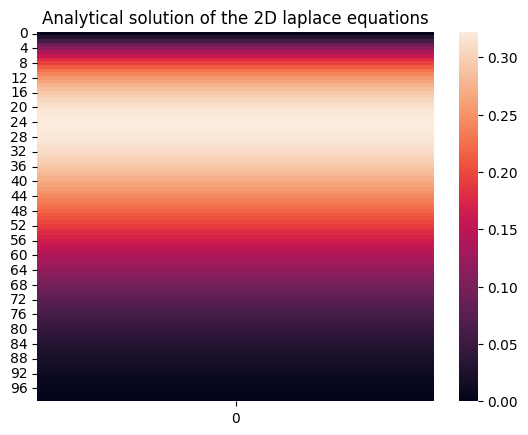

In [37]:
sns.heatmap(analytic_sol)
plt.title("Analytical solution of the 2D laplace equations")
plt.show()